# Analysis and Creation of updating formula for graph edges

## Install Required Packages

In [ ]:
!pip install numpy
!pip install pandas
!pip install networkx
!pip install scikit-learn

## Imports

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

## Creating updating formula

In [3]:
def update_edges(edges, substitutions, lr, baseline_metric_value, current_metric_value):
    updated_edges = list()
    for (u, v, w) in edges:
        try:
            # get substitution occurences for each edge
            edge_subs = substitutions[(u,v)] 
            # updating formula
            new_w = w + lr * (baseline_metric_value - current_metric_value) / edge_subs
            # add the updated edge to the list
            updated_edges.append((u, v, new_w))
        except KeyError:
            print("Something went wrong during updating of edges' weights")
    
    return updated_edges

## Testing updating formula

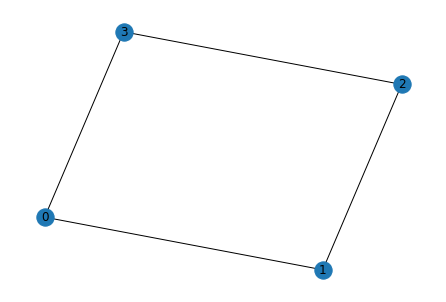

In [13]:
testing_edges = [(0, 1, 2), (1, 2, 2), (2, 3, 2), (3, 0, 2)]

g = nx.Graph()
g.add_weighted_edges_from(testing_edges)
nx.draw(g, with_labels=True)

In [19]:
subs = {(u, v): 1 for (u, v, d) in testing_edges}
new_edges = update_edges(testing_edges, subs, 0.1, 3.0, 2.0)
print(new_edges)

d_w =  0.1 * (3 - 2) / 1

for i in range(len(new_edges)):
    assert round(new_edges[i][2] - testing_edges[i][2], 1) == d_w

print("Assertion test all passed!")

[(0, 1, 2.1), (1, 2, 2.1), (2, 3, 2.1), (3, 0, 2.1)]
Assertion test all passed!


## Creating the complete training process

In [ ]:
def compare_preds(original_p, counter_p):
    pass

In [ ]:
def get_baseline_metric():
    pass

In [ ]:
def train_graph(g, data, preprocessor, model, editor, learning_rate=0.01, th=0.005, max_iterations=100):
    """
    A function that represents the training process for the graph edges. It gets predictions for the original data
    then uses a counterfactual editor to generate counter data and get predictions for them. To get the current_metric
    it compares the two predictions and based on those updates the weights of the selected edges.
    
    :param g: the graph used in Maria's framework
    :param data: a dataframe containing the textual examples we will use to train the graph
    :param preprocessor: a custom class that implements the necessary preprocessing of the data
    :param model: a pretrained model on the dataset
    :param editor: the counterfactual editor used to generate counterfactual data
    """
    
    # first process the original data and get model predictions
    processed_data = preprocessor.process(data)
    original_preds = model.predict(processed_data)
    
    # do the same but for the counterfactual-generated data
    counter_data, selected_edges, substitutions= editor.generate_counterfactuals(g, data)
    processed_counter_data = preprocessor.process(counter_data)
    counter_preds = model.predict(processed_counter_data)
    
    # compare the two predictions to get desired metric
    current_metric = compare_preds(original_preds, counter_preds)
    baseline_metric = get_baseline_metric()
    
    iterations = 0
    # if metric difference is larger than a threshold and iterations are not at high bound
    while abs(current_metric - baseline_metric) >= th and iterations < max_iterations:
        # remove old values of edges from the graph
        g.remove_edges_from(edges)
        updated_edges = update_edges(edges, substitutions, learning_rate, baseline_metric, current_metric)
        # add the edges with the new edges back into the graph
        g.add_weighted_edges_from(updated_edges)
        
        # change the baseline_metric value and update iteration count
        baseline_metric = max(baseline_metric, current_metric)
        iterations += 1

    return g
    